In [3]:
import os
import random
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from alibi_detect.cd import MMDDrift
import random
from matplotlib.colors import ListedColormap
from datetime import date, timedelta

sys.path.append("..")

from utils.utils import *
from baseline_models.temporal.pytorch.optimizer import Optimizer
from baseline_models.temporal.pytorch.utils import *

2022-07-06 19:09:53,940 INFO cyclops.orm     - Database setup, ready to run queries!


In [4]:
PATH = "/mnt/nfs/project/delirium/drift_exp/JULY-04-2022"

In [5]:
admin_data, x, y = get_gemini_data(PATH)

2022-07-06 19:09:53,974 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggregated_events.parquet


Load data from aggregated events...


2022-07-06 19:09:54,327 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggmeta_start_ts.parquet
2022-07-06 19:09:54,532 INFO cyclops.feature_handler - Loading features from file...
2022-07-06 19:09:54,536 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-06 19:09:54,537 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-06 19:09:54,569 INFO cyclops.feature_handler - Found file to load for temporal features...


Load data from feature handler...


2022-07-06 19:09:59,440 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


Load data from admin data...


2022-07-06 19:10:07,885 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggmeta_end_ts.parquet


## Create Data Streams

In [6]:
#####################################################
## a given date contains data from previous two weeks 
#####################################################

start_date = date(2018, 1, 1)
end_date = date(2020, 8, 1)

def daterange(start_date, end_date, stride, window):
    for n in range(int((end_date - start_date).days)):
        if start_date + timedelta(n*stride+window) < end_date:
            yield start_date+ timedelta(n*stride)
            

def get_streams(x, y, admin_data, start_date, end_date, stride, window):
    target_stream_x = []
    target_stream_y = [] 
    measure_dates = []

    admit_df = admin_data[[ENCOUNTER_ID,ADMIT_TIMESTAMP]].sort_values(by=ADMIT_TIMESTAMP)
    for single_date in daterange(start_date, end_date, stride, window):
        if single_date.month ==1 and single_date.day == 1:
            print(single_date.strftime("%Y-%m-%d"),"-",(single_date+timedelta(days=window)).strftime("%Y-%m-%d"))
        encounters_inwindow = admit_df.loc[((single_date+timedelta(days=window)).strftime("%Y-%m-%d") > admit_df[ADMIT_TIMESTAMP].dt.strftime("%Y-%m-%d")) 
                           & (admit_df[ADMIT_TIMESTAMP].dt.strftime("%Y-%m-%d") >= single_date.strftime("%Y-%m-%d")), ENCOUNTER_ID].unique()
        encounter_ids = x.index.get_level_values(0).unique()
        x_inwindow = x.loc[x.index.get_level_values(0).isin(encounters_inwindow)]
        y_inwindow = y[np.in1d(encounter_ids, encounters_inwindow)]
        if not x_inwindow.empty:
            target_stream_x.append(x_inwindow)
            target_stream_y.append(y_inwindow)
            measure_dates.append((single_date+timedelta(days=window)).strftime("%Y-%m-%d"))
    return(target_stream_x, target_stream_y, measure_dates)

x_test_stream, y_test_stream, measure_dates_test = get_streams(x, y, admin_data, start_date, end_date, stride=1, window=1)

2018-01-01 - 2018-01-02
2019-01-01 - 2019-01-02
2020-01-01 - 2020-01-02


## Rolling Window (14 days)

In [7]:
# compare data for patients admitted in the same date ACROSS TIMESTEPS (e.g. all patients have same admit date) --> patient deteroriation
# compare data for patients ACROSS DATE (timestep agnostic) --> more of dataset shift 
# compare data for group of patients ACROSS DATE and TIMESTEP --> dataset shift + deterioration
threshold = 0.05
num_timesteps = 6
stat_window=14
lookup_window=14
stride=1
random.seed(1)

#####################################################
## rolling window - not cumulatively including data and no adjustment made when drift occurs
##################################################### 
def rolling_window(stat_window, lookup_window, stride, num_timesteps, series, threshold,custom_ref=None):

    p_vals = np.asarray([])
    dist_vals = np.asarray([])
    i = 0 
    if custom_ref is not None:
        prev = reshape_inputs(custom_ref, num_timesteps)
        
    while i+stat_window+lookup_window < len(series):
        feat_index = 0
        
        if custom_ref is None:
            prev = pd.concat(series[i:i+stat_window])
            prev = prev[~prev.index.duplicated(keep='first')]
            prev = reshape_inputs(prev, num_timesteps)
            #prev = prev.reshape(prev.shape[0]*prev.shape[1],prev.shape[2])
            
        next = pd.concat(series[i+lookup_window:i+lookup_window+stat_window])
        next = next[~next.index.duplicated(keep='first')]
        next = reshape_inputs(next, num_timesteps)
        #next = next.reshape(next.shape[0]*next.shape[1],next.shape[2])
        
        if next.shape[0]<=2 or prev.shape[0]<=2:
            break
        
        ## run distribution shift check here
        cd = MMDDrift(prev, backend='pytorch', p_val=.05)
        preds = cd.predict(next, return_p_val=True, return_distance=True)
        p_val = preds['data']['p_val']
        if p_val < threshold:
            print("P-value below threshold.")
            print(i,"-", i+stat_window,"-->",i+lookup_window,"-",i+stat_window+lookup_window,"\tP-Value: ",p_val)
        dist_val = preds['data']['distance']
        dist_vals = np.concatenate((dist_vals, np.repeat(dist_val, 1)))
        p_vals = np.concatenate((p_vals, np.repeat(p_val, 1)))
        i += stride
            
    return dist_vals, p_vals

#dist_vals_test, p_vals_test = rolling_window(stat_window, lookup_window, stride, num_timesteps, x_test_stream, threshold)

In [ ]:
measure_dates_test_14d = [(datetime.datetime.strptime(date,"%Y-%m-%d")+datetime.timedelta(days=stat_window*2+lookup_window)).strftime("%Y-%m-%d") for date in measure_dates_test]
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,8))
fig.suptitle('Rolling Windowing')

end = len(p_vals_test)
results = percentile_list = pd.DataFrame(
    {'dates': measure_dates_test_14d[1:end],
     'p_val_val': p_vals_test[1:end],
     'dist metric_val': dist_vals_test[1:end],
     'detection': np.where(p_vals_test[1:end]<threshold,1,0)
    })


cmap = ListedColormap(['lightgrey','red'])
ax1.plot(measure_dates_test_14d[1:end], p_vals_test[1:end], '.-', color="red")
ax1.set_xlim(measure_dates_test_14d[1],measure_dates_test_14d[end])
ax1.axhline(y=0.05, color='black', linestyle='--')
ax1.set_ylabel('P-Values')
ax1.set_xticklabels([])
ax1.pcolorfast(ax1.get_xlim(), ax1.get_ylim(),results['detection'].values[np.newaxis], cmap = cmap, alpha = 0.4)
        
ax2.plot(measure_dates_test_14d[1:end], dist_vals_test[1:end], '.-',color="blue")
ax2.set_xlim(measure_dates_test_14d[1],measure_dates_test_14d[end])
ax2.set_xlabel('time (s)')
ax2.set_ylabel('Distance Metric')
ax2.tick_params(axis='x', labelrotation=45)
ax2.pcolorfast(ax2.get_xlim(), ax2.get_ylim(),results['detection'].values[np.newaxis], cmap = cmap, alpha = 0.4)
for index, label in enumerate(ax2.xaxis.get_ticklabels()):
    if index % 28 != 0:
        label.set_visible(False)

plt.show()

## Rolling Window (60 Days)

In [216]:
stat_window=14
lookup_window=60
dist_vals_test, p_vals_test = rolling_window(stat_window, lookup_window, stride, num_timesteps, x_test_stream, threshold)

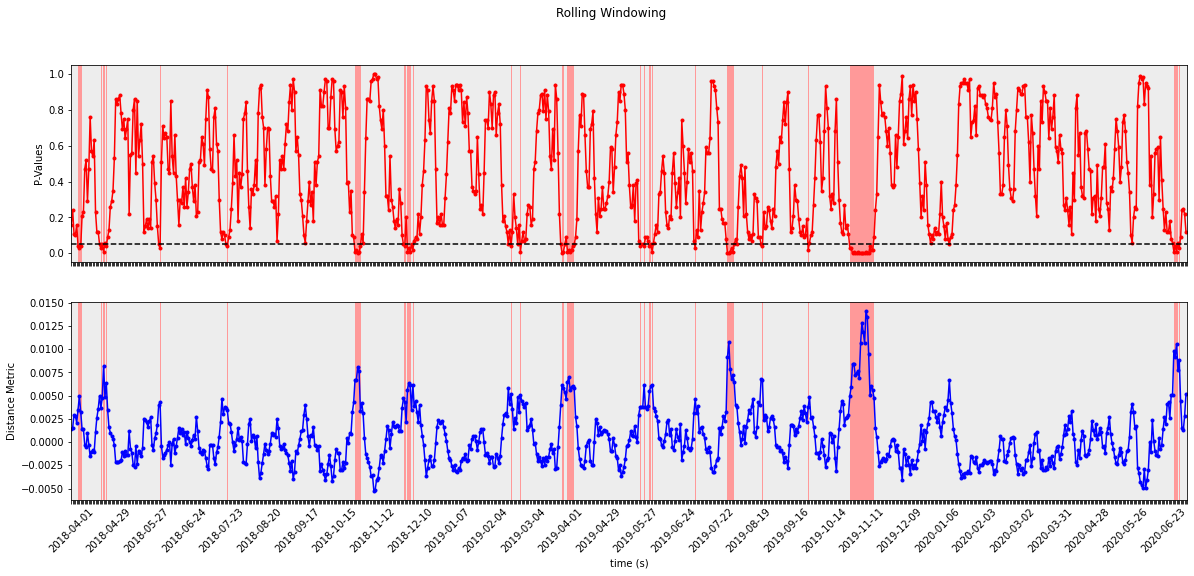

In [223]:
measure_dates_test_60d = [(datetime.datetime.strptime(date,"%Y-%m-%d")+datetime.timedelta(days=stat_window*2+lookup_window)).strftime("%Y-%m-%d") for date in measure_dates_test]
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,8))
fig.suptitle('Rolling Windowing')

end = len(p_vals_test)
results = percentile_list = pd.DataFrame(
    {'dates': measure_dates_test_60d[1:end],
     'p_val_val': p_vals_test[1:end],
     'dist metric_val': dist_vals_test[1:end],
     'detection': np.where(p_vals_test[1:end]<threshold,1,0)
    })


cmap = ListedColormap(['lightgrey','red'])
ax1.plot(measure_dates_test_60d[1:end], p_vals_test[1:end], '.-', color="red")
ax1.set_xlim(measure_dates_test_60d[1],measure_dates_test_60d[end])
ax1.axhline(y=0.05, color='black', linestyle='--')
ax1.set_ylabel('P-Values')
ax1.set_xticklabels([])
ax1.pcolorfast(ax1.get_xlim(), ax1.get_ylim(),results['detection'].values[np.newaxis], cmap = cmap, alpha = 0.4)
        
ax2.plot(measure_dates_test_60d[1:end], dist_vals_test[1:end], '.-',color="blue")
ax2.set_xlim(measure_dates_test_60d[1],measure_dates_test_60d[end])
ax2.set_xlabel('time (s)')
ax2.set_ylabel('Distance Metric')
ax2.tick_params(axis='x', labelrotation=45)
ax2.pcolorfast(ax2.get_xlim(), ax2.get_ylim(),results['detection'].values[np.newaxis], cmap = cmap, alpha = 0.4)
for index, label in enumerate(ax2.xaxis.get_ticklabels()):
    if index % 28 != 0:
        label.set_visible(False)

plt.show()

## Rolling Window (120 Days)

In [ ]:
stat_window=14
lookup_window=120
dist_vals_test, p_vals_test = rolling_window(stat_window, lookup_window, stride, num_timesteps, x_test_stream, threshold)
measure_dates_test_120d = [(datetime.datetime.strptime(date,"%Y-%m-%d")+datetime.timedelta(days=stat_window*2+lookup_window)).strftime("%Y-%m-%d") for date in measure_dates_test]

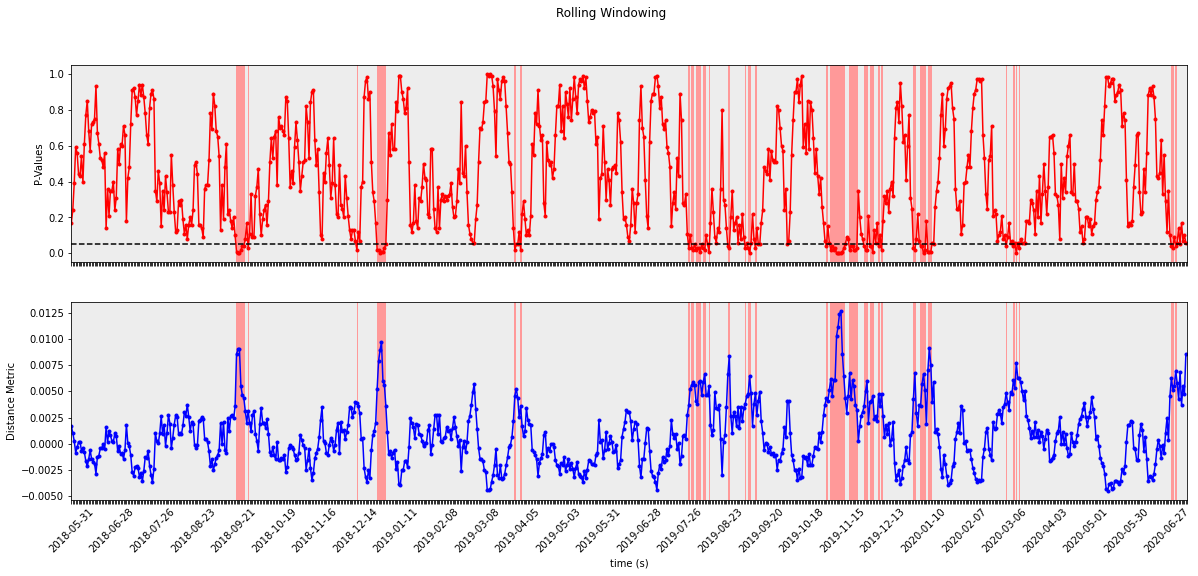

In [227]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,8))
fig.suptitle('Rolling Windowing')

end = len(p_vals_test)
results = percentile_list = pd.DataFrame(
    {'dates': measure_dates_test_120d[1:end],
     'p_val_val': p_vals_test[1:end],
     'dist metric_val': dist_vals_test[1:end],
     'detection': np.where(p_vals_test[1:end]<threshold,1,0)
    })


cmap = ListedColormap(['lightgrey','red'])
ax1.plot(measure_dates_test_120d[1:end], p_vals_test[1:end], '.-', color="red")
ax1.set_xlim(measure_dates_test_120d[1],measure_dates_test_120d[end])
ax1.axhline(y=0.05, color='black', linestyle='--')
ax1.set_ylabel('P-Values')
ax1.set_xticklabels([])
ax1.pcolorfast(ax1.get_xlim(), ax1.get_ylim(),results['detection'].values[np.newaxis], cmap = cmap, alpha = 0.4)
        
ax2.plot(measure_dates_test_120d[1:end], dist_vals_test[1:end], '.-',color="blue")
ax2.set_xlim(measure_dates_test_120d[1],measure_dates_test_120d[end])
ax2.set_xlabel('time (s)')
ax2.set_ylabel('Distance Metric')
ax2.tick_params(axis='x', labelrotation=45)
ax2.pcolorfast(ax2.get_xlim(), ax2.get_ylim(),results['detection'].values[np.newaxis], cmap = cmap, alpha = 0.4)
for index, label in enumerate(ax2.xaxis.get_ticklabels()):
    if index % 28 != 0:
        label.set_visible(False)

plt.show()

## Longer rolling window (120 days) with longer stat window (30 days)

In [ ]:
stat_window=30
lookup_window=120
dist_vals_test, p_vals_test = rolling_window(stat_window, lookup_window, stride, num_timesteps, x_test_stream, threshold)

In [19]:
measure_dates_test[0]

'2018-01-02'

In [18]:
measure_dates_test_120d = [(datetime.datetime.strptime(date,"%Y-%m-%d")+datetime.timedelta(days=lookup_window+stat_window*2)).strftime("%Y-%m-%d") for date in measure_dates_test]
measure_dates_test_120d[0]

'2018-07-01'

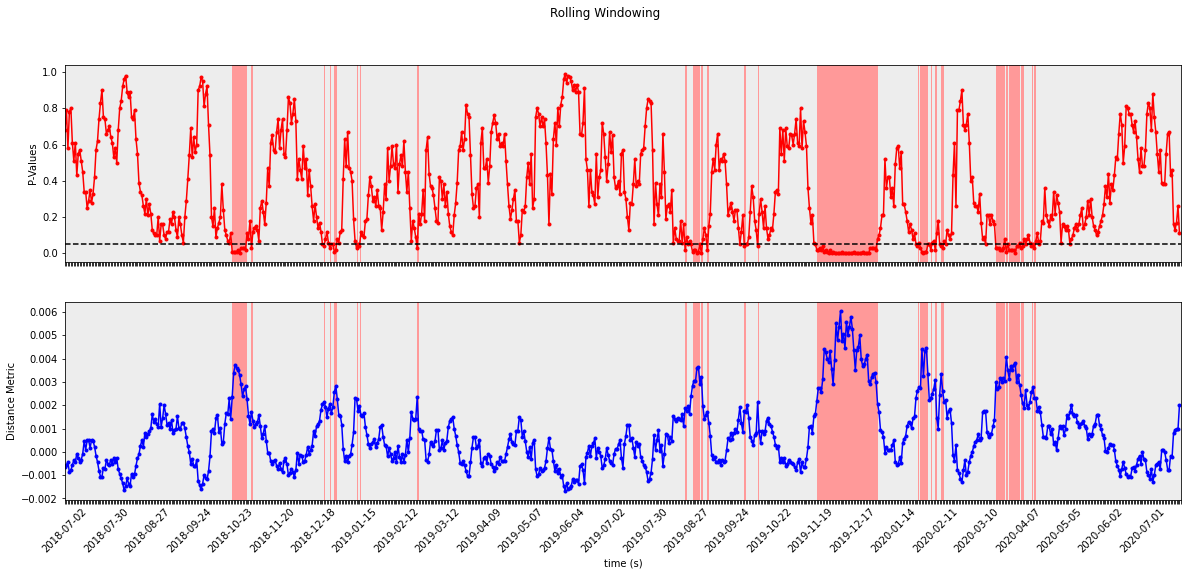

In [231]:
end = len(p_vals_test)
measure_dates_test_120d = [(datetime.datetime.strptime(date,"%Y-%m-%d")+datetime.timedelta(days=lookup_window+stat_window*2)).strftime("%Y-%m-%d") for date in measure_dates_test]
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,8))
fig.suptitle('Rolling Windowing')

results = percentile_list = pd.DataFrame(
    {'dates': measure_dates_test_120d[1:end],
     'p_val_val': p_vals_test[1:end],
     'dist metric_val': dist_vals_test[1:end],
     'detection': np.where(p_vals_test[1:end]<threshold,1,0)
    })


cmap = ListedColormap(['lightgrey','red'])
ax1.plot(measure_dates_test_120d[1:end], p_vals_test[1:end], '.-', color="red")
ax1.set_xlim(measure_dates_test_120d[1],measure_dates_test_120d[end])
ax1.axhline(y=0.05, color='black', linestyle='--')
ax1.set_ylabel('P-Values')
ax1.set_xticklabels([])
ax1.pcolorfast(ax1.get_xlim(), ax1.get_ylim(),results['detection'].values[np.newaxis], cmap = cmap, alpha = 0.4)
        
ax2.plot(measure_dates_test_120d[1:end], dist_vals_test[1:end], '.-',color="blue")
ax2.set_xlim(measure_dates_test_120d[1],measure_dates_test_120d[end])
ax2.set_xlabel('time (s)')
ax2.set_ylabel('Distance Metric')
ax2.tick_params(axis='x', labelrotation=45)
ax2.pcolorfast(ax2.get_xlim(), ax2.get_ylim(),results['detection'].values[np.newaxis], cmap = cmap, alpha = 0.4)
for index, label in enumerate(ax2.xaxis.get_ticklabels()):
    if index % 28 != 0:
        label.set_visible(False)

plt.show()

## Rolling window with year look ahead

In [ ]:
stat_window=30
lookup_window=365
dist_vals_test, p_vals_test = rolling_window(stat_window, lookup_window, stride, num_timesteps, x_test_stream, threshold)

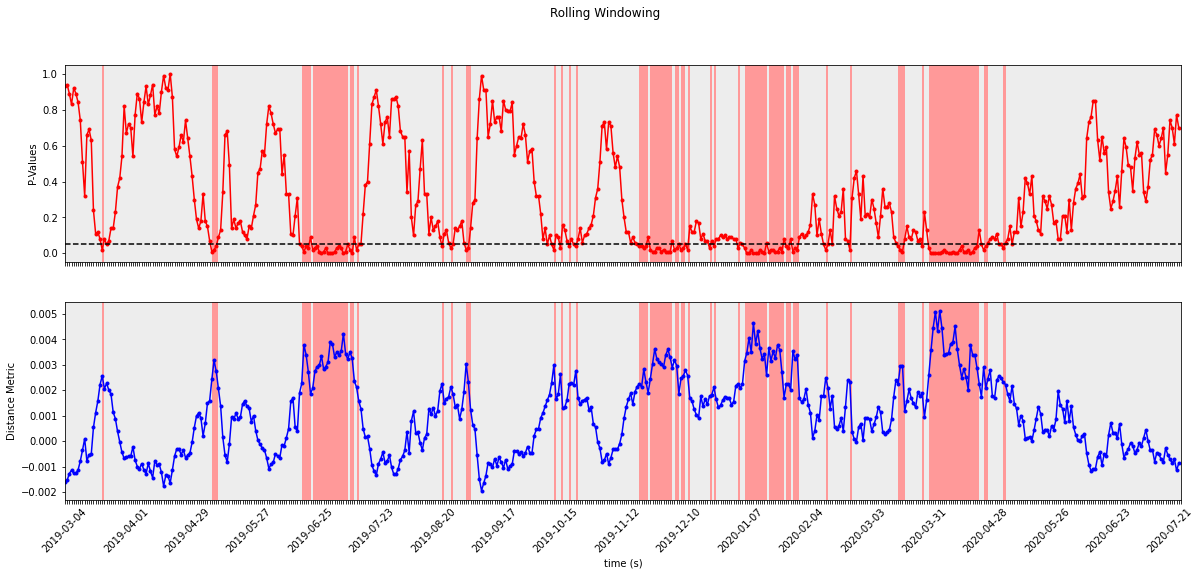

In [238]:
end = len(p_vals_test)
measure_dates_test_year = [(datetime.datetime.strptime(date,"%Y-%m-%d")+datetime.timedelta(days=lookup_window+stat_window*2)).strftime("%Y-%m-%d") for date in measure_dates_test]
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,8))
fig.suptitle('Rolling Windowing')

results = percentile_list = pd.DataFrame(
    {'dates': measure_dates_test_year[1:end],
     'p_val_val': p_vals_test[1:end],
     'dist metric_val': dist_vals_test[1:end],
     'detection': np.where(p_vals_test[1:end]<threshold,1,0)
    })


cmap = ListedColormap(['lightgrey','red'])
ax1.plot(measure_dates_test_year[1:end], p_vals_test[1:end], '.-', color="red")
ax1.set_xlim(measure_dates_test_year[1],measure_dates_test_year[end])
ax1.axhline(y=0.05, color='black', linestyle='--')
ax1.set_ylabel('P-Values')
ax1.set_xticklabels([])
ax1.pcolorfast(ax1.get_xlim(), ax1.get_ylim(),results['detection'].values[np.newaxis], cmap = cmap, alpha = 0.4)
        
ax2.plot(measure_dates_test_year[1:end], dist_vals_test[1:end], '.-',color="blue")
ax2.set_xlim(measure_dates_test_year[1],measure_dates_test_year[end])
ax2.set_xlabel('time (s)')
ax2.set_ylabel('Distance Metric')
ax2.tick_params(axis='x', labelrotation=45)
ax2.pcolorfast(ax2.get_xlim(), ax2.get_ylim(),results['detection'].values[np.newaxis], cmap = cmap, alpha = 0.4)
for index, label in enumerate(ax2.xaxis.get_ticklabels()):
    if index % 28 != 0:
        label.set_visible(False)

plt.show()